In [25]:
#Environment for BERT Word embedding notebook
import torch
from transformers import (AutoModelWithLMHead, 
                          AutoTokenizer, 
                          BertConfig,BertTokenizer,BertModel)
import matplotlib.pyplot as plt

In [26]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [27]:
# Load pre-trained model tokenizer (vocabulary-multilingual)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [28]:
# Bert need special kind of input format, with special tokens to mark beginning([CLS]) and seperation/end([SEP]).
text = "My Name is Uttam Asodariya and I am a FAU student." #simple example
marked_text = "[CLS] " + text + " [SEP]"

'''Now, we need to tokenize our senteces(text) according to BERT's vocabulary. For each tokenized sentence, 
   BERT requires input ids. EX: bird-->2293 
   '''

tokenized_text = tokenizer.tokenize(marked_text) # Tokenize our sentence with the BERT tokenizer.

indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text) # Map the token strings to their vocabulary indeces.

# Print out the tokens.
print(tokenized_text)
print (indexed_tokens)


['[CLS]', 'my', 'name', 'is', 'ut', '##tam', 'as', '##oda', '##ri', '##ya', 'and', 'i', 'am', 'a', 'fa', '##u', 'student', '.', '[SEP]']
[101, 2026, 2171, 2003, 21183, 15464, 2004, 13390, 3089, 3148, 1998, 1045, 2572, 1037, 6904, 2226, 3076, 1012, 102]


In [35]:
import torch
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])

In [31]:
#Run the text through BERT, get the output and collect all of the hidden states produced from all 12 layers.
with torch.no_grad():
    outputs = model(tokens_tensor)
    last_hidden_state = outputs[0]
    word_embed = last_hidden_state
    hidden_states = outputs[2]

In [32]:
'''Here, Our main goal is word embedding so we only limit out vision untill encoding part,
   which is hidden_state in BERT model. Full set of hidden states of model, stored in the object hidden_states.
   It has following for dimension: 1)The Layer number
                                   2)The batch number (num of sentences)
                                   3)The word/token number (maximum length of sentences)
                                   4)The hidden unit/feature number (768 features)
   '''

   
print ("Number of layers:", len(hidden_states), "  (Input embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (Input embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 19
Number of hidden units: 768


In [33]:
'''
Every token have word embedding of length 768. 
As we have 12 hidden layer so we get output after each hidden layer and can be used as a word embedding .
But, Question is, which is the best?. Vary combinations feeding as ainput to BiLSTM for named entity recognition
task and observeing the F1 Score. It shows sum of last 4 layers works well
'''


# initial embeddings can be taken from 0th layer of hidden states
word_embed_2 = hidden_states[0]
# sum of all hidden states
word_embed_3 = torch.stack(hidden_states).sum(0)
# sum of second to last layer
word_embed_4 = torch.stack(hidden_states[2:]).sum(0)
# sum of last four layer
word_embed_5 = torch.stack(hidden_states[-4:]).sum(0)
# concatenate last four layers
word_embed_6 = torch.cat([hidden_states[i] for i in [-1,-2,-3,-4]], dim=-1)
print(word_embed_5.shape)


torch.Size([1, 19, 768])


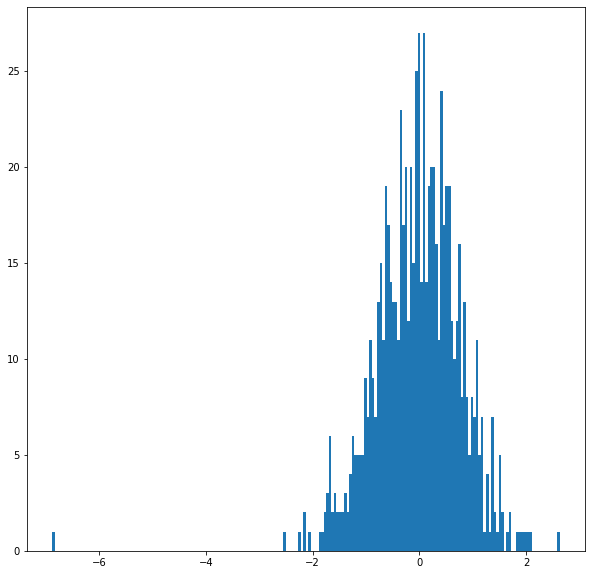

In [34]:
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()